In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs


In [ ]:
# Fix random seed for reproducibility
np.random.seed(42)

# Generate synthetic data
X, true_labels = make_blobs(
    n_samples=600,
    centers=3,
    cluster_std=[0.5, 0.8, 0.3],
    random_state=42
)


In [ ]:
from sklearn.mixture import BayesianGaussianMixture

dp_gmm = BayesianGaussianMixture(
    n_components=15,                    # truncation level (upper bound)
    covariance_type="full",
    weight_concentration_prior_type="dirichlet_process",
    weight_concentration_prior=1.0,      # α (concentration parameter)
    max_iter=1000,
    random_state=42
)

dp_gmm.fit(X)

# Infer cluster assignments
labels = dp_gmm.predict(X)


In [ ]:
weights = dp_gmm.weights_

for i, w in enumerate(weights):
    if w > 0.01:  # show only meaningful clusters
        print(f"Component {i}: weight = {w:.3f}")


Component 12: weight = 0.328
Component 13: weight = 0.327
Component 14: weight = 0.325


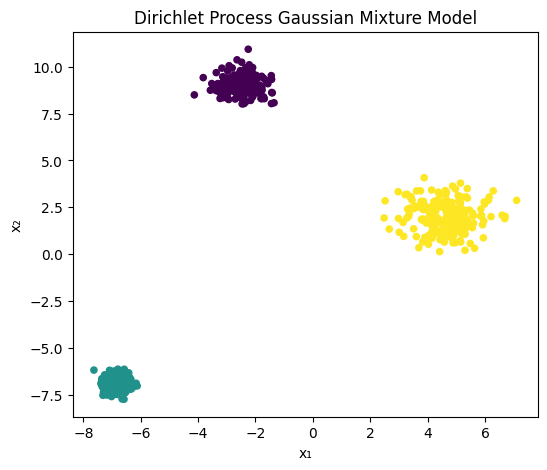

In [ ]:
plt.figure(figsize=(6, 5))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap="viridis", s=20)
plt.title("Dirichlet Process Gaussian Mixture Model")
plt.xlabel("x₁")
plt.ylabel("x₂")
plt.show()


**Hierarchical Non Parametric Bayesian Classification from Scratch**

In [ ]:
import numpy as np
from scipy.stats import multivariate_normal
from scipy.special import gammaln

# Generate synthetic data
np.random.seed(42)

X, true_labels = make_blobs(
    n_samples=600,
    centers=3,
    cluster_std=[0.5, 0.8, 0.3],
    random_state=42
)

N, D = X.shape



**Non - Parametric Bayesian Classification (Hierarchical Bayesian Model)**
<br><br>
The following code is based on the following:
<br><br>
$$
\begin{align}
G & \sim \text{DP}(\alpha, G_0)\\
(\mu_k, \Sigma_k) & \sim  G_0\\
z_i | z_{-1} & \sim CRP(\alpha)\\
x_i | z_{-1}  = k, \mu_k, \Sigma_k  & \sim N( \mu_k, \Sigma_k)
\end{align}
$$
<br><br>

In [ ]:
#Normal–Inverse-Wishart prior (conjugate)
def niw_posterior(Xk, mu0, kappa0, Psi0, nu0):
    Nk = Xk.shape[0]

    if Nk == 0:
        return mu0, kappa0, Psi0, nu0

    xbar = Xk.mean(axis=0)
    S = ((Xk - xbar).T @ (Xk - xbar))

    kappa_n = kappa0 + Nk
    nu_n = nu0 + Nk
    mu_n = (kappa0 * mu0 + Nk * xbar) / kappa_n

    diff = (xbar - mu0).reshape(-1, 1)
    Psi_n = Psi0 + S + (kappa0 * Nk / kappa_n) * (diff @ diff.T)

    return mu_n, kappa_n, Psi_n, nu_n



In [ ]:
#Multivariate Student-t predictive distribution
def student_t_logpdf(x, mu, Sigma, nu):
    d = len(x)
    xc = x - mu
    inv = np.linalg.inv(Sigma)

    term1 = gammaln((nu + d) / 2) - gammaln(nu / 2)
    term2 = -0.5 * np.log(np.linalg.det(Sigma))
    term3 = - (d / 2) * np.log(nu * np.pi)
    term4 = - (nu + d) / 2 * np.log(1 + (xc @ inv @ xc) / nu)

    return term1 + term2 + term3 + term4



In [ ]:
#Collapsed Gibbs Sampler (CRP)
def dp_gmm_gibbs(X, alpha=1.0, iters=100):
    N, D = X.shape

    # NIW hyperparameters
    mu0 = np.zeros(D)
    kappa0 = 0.01
    nu0 = D + 2
    Psi0 = np.eye(D)

    # Initialize: all points in one cluster
    z = np.zeros(N, dtype=int)
    clusters = {0: list(range(N))}

    for it in range(iters):
        for i in range(N):
            xi = X[i]
            ki = z[i]

            # Remove point
            clusters[ki].remove(i)
            if len(clusters[ki]) == 0:
                del clusters[ki]
                z[z > ki] -= 1
                clusters = {j: v for j, v in enumerate(clusters.values())}

            log_probs = []

            # Existing clusters
            for idxs in clusters.values():
                Xk = X[idxs]
                mu_n, kappa_n, Psi_n, nu_n = niw_posterior(
                    Xk, mu0, kappa0, Psi0, nu0
                )
                scale = (kappa_n + 1) / (kappa_n * (nu_n - D + 1)) * Psi_n
                lp = np.log(len(idxs)) + student_t_logpdf(
                    xi, mu_n, scale, nu_n - D + 1
                )
                log_probs.append(lp)

            # New cluster
            scale0 = (kappa0 + 1) / (kappa0 * (nu0 - D + 1)) * Psi0
            lp_new = np.log(alpha) + student_t_logpdf(
                xi, mu0, scale0, nu0 - D + 1
            )
            log_probs.append(lp_new)

            # Normalize & sample
            log_probs = np.array(log_probs)
            probs = np.exp(log_probs - log_probs.max())
            probs /= probs.sum()

            k_new = np.random.choice(len(probs), p=probs)

            if k_new == len(clusters):
                clusters[k_new] = []

            clusters[k_new].append(i)
            z[i] = k_new

        if it % 10 == 0:
            print(f"Iteration {it}, active clusters = {len(clusters)}")

    return z, clusters



In [ ]:
#Run the model
labels, clusters = dp_gmm_gibbs(X, alpha=1.0, iters=100)

print(f"Final number of inferred clusters: {len(clusters)}")



Iteration 0, active clusters = 2
Iteration 10, active clusters = 4
Iteration 20, active clusters = 4
Iteration 30, active clusters = 3
Iteration 40, active clusters = 4
Iteration 50, active clusters = 3
Iteration 60, active clusters = 3
Iteration 70, active clusters = 3
Iteration 80, active clusters = 4
Iteration 90, active clusters = 3
Final number of inferred clusters: 3


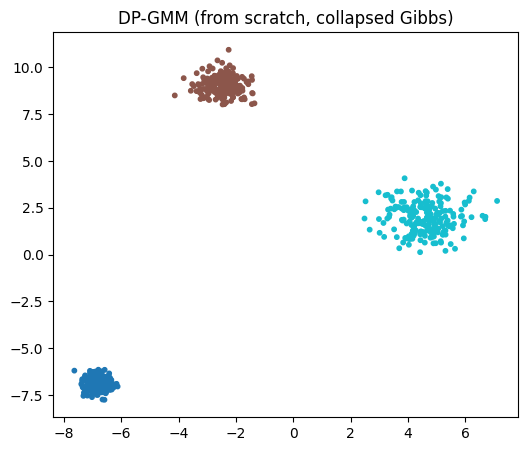

In [ ]:
#Plot the results
plt.figure(figsize=(6, 5))
plt.scatter(X[:, 0], X[:, 1], c=labels, s=10, cmap="tab10")
plt.title("DP-GMM (from scratch, collapsed Gibbs)")
plt.show()
